In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
import re
from gensim import corpora
import gensim
from gensim.models import LdaModel, TfidfModel
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import pyLDAvis.gensim_models


%matplotlib inline

/Users/yfsong/opt/anaconda3/envs/dis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


## Data Loading

### Character Metadata

In [2]:
df_character = pd.read_csv("./MovieSummaries/character.metadata.tsv", sep='\t', header=None)
df_character.columns = ['Wikipedia movie ID', 
'Freebase movie ID', 
'Movie release date',
'Character name',
'Actor date of birth', 
'Actor gender', 
'Actor height(in meters)', 
'Actor ethnicity(Freebase ID)', 
'Actor name', 
'Actor age at movie release',
'Freebase character/actor map ID',
'Freebase character ID',
'Freebase actor ID']
df_character.head()

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height(in meters),Actor ethnicity(Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [3]:
# number of samples without missing values
print("{}/{} samples without any missing value.".format(len(df_character.dropna()), len(df_character)))


45264/450669 samples without any missing value.


### Movie Metadata

In [4]:
df_movie = pd.read_csv("./MovieSummaries/movie.metadata.tsv", sep='\t', header=None)
df_movie.columns = ['Wikipedia movie ID', 'Freebase movie ID', 'Name', 'Release date', 'Revenue', 'Runtime', 'Languages', 'Countries', 'Genres']
df_movie.head()

,Wikipedia movie ID,Freebase movie ID,Name,Release date,Revenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


### Plot summary

In [5]:
df_summary = pd.read_csv("./MovieSummaries/plot_summaries.txt", sep='\t', header=None)
df_summary.columns = ['Wikipedia movie ID', 'Summary']
df_summary.head()

,Wikipedia movie ID,Summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


### Name Cluster

In [6]:
df_name_cluster = pd.read_csv("./MovieSummaries/name.clusters.txt", sep='\t', header=None)
df_name_cluster.columns = ['Character Name', 'Freebase Movie ID']
df_name_cluster.head()

,Character Name,Freebase Movie ID
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


### Tvtropes Cluster

In [7]:
chartype_path = "./MovieSummaries/tvtropes.clusters.txt"


def read_tvtropes(char_cluster_path):
    df = pd.read_csv(char_cluster_path, sep='\t', header=None)
    df.columns = ['Type', 'raw info']
    # extract information from "Raw Info"
    for i in range(len(df)):
        char_info = json.loads(df.loc[i, 'raw info'])
        for name,val in char_info.items():
            df.loc[i, name.title()] = val
    df.drop('raw info', axis=1, inplace=True)
    return df

df_chartype = read_tvtropes(chartype_path)
print(df_chartype.shape)
df_chartype.head()

(501, 5)


,Type,Char,Movie,Id,Actor
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


## Data Wrangling

#### Release Date Processing

In [8]:
print("{}/{} samples without any missing value.".format(len(df_movie.dropna()), len(df_movie)))
df_movie = df_movie.dropna().reset_index(drop=True)

8243/81741 samples without any missing value.


In [9]:
# transform Release date to integer, month and day are dropped for simplicity.
df_movie["Release date"] = df_movie["Release date"].apply(lambda x: int(x.split('-')[0]))

In [10]:
# only consider movies released after 1920
df_movie = df_movie[df_movie["Release date"] >= 1920]

In [11]:
# plot Release date - Revenue plot
# g = sns.jointplot(x=df_movie["Release date"], y=np.log(df_movie["Revenue"]), kind="reg")
# g.set_axis_labels(ylabel="log of Revenue")

#### Revenue Processing

In [12]:
def ratio_per_year(x):
    sum = x.Revenue.sum()
    return x.Revenue/sum

In [13]:
group_by_year = df_movie.groupby("Release date").apply(ratio_per_year)
group_by_year

Release date      
1920          2574    1.000000
1921          593     0.569620
              3314    0.113924
              4117    0.316456
1923          12      0.456395
                        ...   
2012          7959    0.002308
              7982    0.012923
              8037    0.010032
              8061    0.004218
              8139    0.003447
Name: Revenue, Length: 8240, dtype: float64

In [14]:
for i,v in group_by_year.iteritems():
    df_movie.loc[i[1], "Revenue_ratio"] = v

df_movie

,Wikipedia movie ID,Freebase movie ID,Name,Release date,Revenue,Runtime,Languages,Countries,Genres,Revenue_ratio
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",0.000946
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",0.153143
2,171005,/m/016ywb,Henry V,1989,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",0.001675
3,77856,/m/0kcn7,Mary Poppins,1964,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",0.303695
4,612710,/m/02wjqm,New Rose Hotel,1999,21521.0,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",0.000002
...,...,...,...,...,...,...,...,...,...,...
8238,1191380,/m/04f_y7,Wilde,1997,2158775.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/014tss"": ""Kingdom of Great Britain"", ""/m/...","{""/m/0hn10"": ""LGBT"", ""/m/017fp"": ""Biography"", ...",0.000175
8239,54540,/m/0f7hw,Coming to America,1988,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",0.059681
8240,7761830,/m/0kvgqb,Spaced Invaders,1990,15369573.0,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3mt0"": ""Alien Film"", ""/m/06n90"": ""Scie...",0.002320
8241,1918494,/m/0660qx,State and Main,2000,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/0gf28"": ""Parody"", ""/m/09n5t_"": ""Americana...",0.000555


### Plot Summary Processing

In [15]:
small_sample_summary = df_summary[:1000]
small_sample_summary

,Wikipedia movie ID,Summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...
...,...,...
995,18994794,The story tells of a North Korean father and h...
996,19398524,Wally had finished filling little Marianne Edw...
997,5628492,"Aloysius ""Al"" Reilly is a young assistant dis..."
998,1417388,"Smart, successful and sexy, Jackson Smith , Br..."


In [16]:
stopWords = set(stopwords.words('english'))

data_summaries = []
for i,v in small_sample_summary.iterrows():
    sentence =[]
    line = re.sub(r"[{}]+".format(punctuation)," ",v[1])
    words = word_tokenize(line)
    for w in words:
        if w not in stopWords and w.lower() not in stopWords:
            sentence.append(w)
    data_summaries.append(sentence)

In [17]:
data = [content for content in data_summaries]
dictionary = corpora.Dictionary(data)
# dictionary.save(r'../data/dictionary.dict')

In [18]:
corpus = [dictionary.doc2bow(s) for s in data]

tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

## Data Analysis

### Relationship between Movie Country and Movie Revenue

In [19]:
df_movie.head()

,Wikipedia movie ID,Freebase movie ID,Name,Release date,Revenue,Runtime,Languages,Countries,Genres,Revenue_ratio
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",0.000946
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",0.153143
2,171005,/m/016ywb,Henry V,1989,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",0.001675
3,77856,/m/0kcn7,Mary Poppins,1964,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",0.303695
4,612710,/m/02wjqm,New Rose Hotel,1999,21521.0,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",0.000002


In [20]:
from collections import Counter, defaultdict

# movie revenue for each country
country_revenue = defaultdict(list)
for index, row in df_movie.iterrows():
    countries = json.loads(row["Countries"]).values()
    if len(countries) >= 2:
        continue
    for country in countries:
        country_revenue[country].append(row["Revenue"])

print("Total {} countries.".format(len(country_revenue)))

Total 40 countries.


Top 10 country, revenue


Text(0.5, 1.0, 'average movie revenue for top 10 countries')

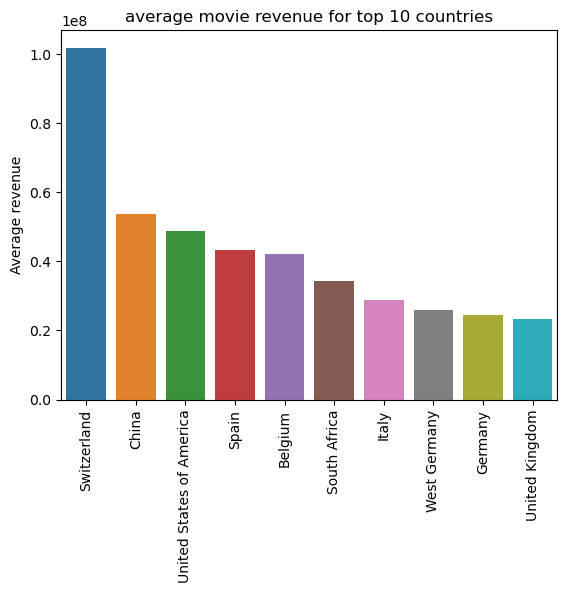

In [21]:
# mean for each country
mean_ctry_rev = {k:sum(v)/len(v) for k,v in country_revenue.items()}
# sroted mean for each country
sorted_mcr = sorted(mean_ctry_rev.items(), key=lambda x:x[1], reverse=True)
sorted_mcr = pd.Series(*list(zip(*sorted_mcr))[::-1], name="Average revenue")

topk = 10
print("Top {} country, revenue".format(topk))
sns.barplot(x=sorted_mcr.index[:topk], y=sorted_mcr[:topk])
plt.ylabel("Average revenue")
plt.xticks(rotation=90)
plt.title("average movie revenue for top {} countries".format(topk))

### Relationship between Movie Language and Movie Revenue

In [22]:
from collections import Counter, defaultdict

# movie revenue for each language
language_revenue = defaultdict(list)
language_count = Counter()
for index, row in df_movie.iterrows():
    languages = json.loads(row["Languages"]).values()
    # if len(languages) >= 2:
    #     continue
    for language in languages:
        language_count[language] += 1
        language_revenue[language].append(row["Revenue"])

print("Total {} languages.".format(len(country_revenue)))

Total 40 languages.


Top 10 language, revenue


Text(0.5, 1.0, 'average movie revenue for top 10 languages')

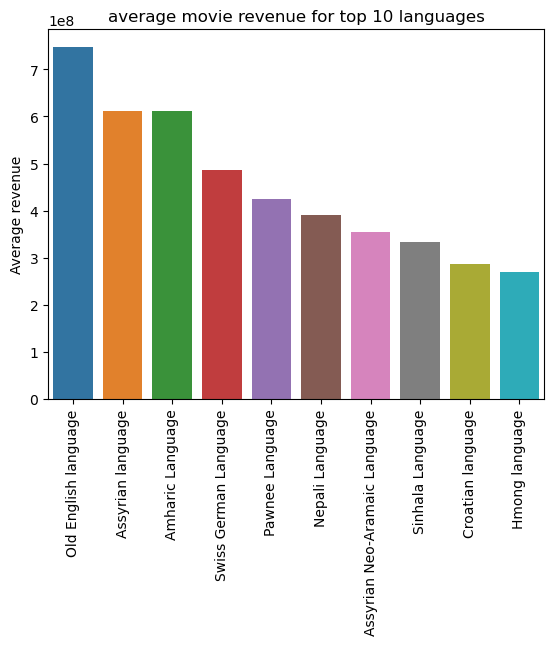

In [23]:
# mean for each language
mean_lang_rev = {k:sum(v)/len(v) for k,v in language_revenue.items()}
# sroted mean for each language
sorted_mlr = sorted(mean_lang_rev.items(), key=lambda x:x[1], reverse=True)
sorted_mlr = pd.Series(*list(zip(*sorted_mlr))[::-1], name="Average revenue")

topk = 10
print("Top {} language, revenue".format(topk))
sns.barplot(x=sorted_mlr.index[:topk], y=sorted_mlr[:topk])
plt.ylabel("Average revenue")
plt.xticks(rotation=90)
plt.title("average movie revenue for top {} languages".format(topk))

Text(0.5, 1.0, 'Revenue - Release data')

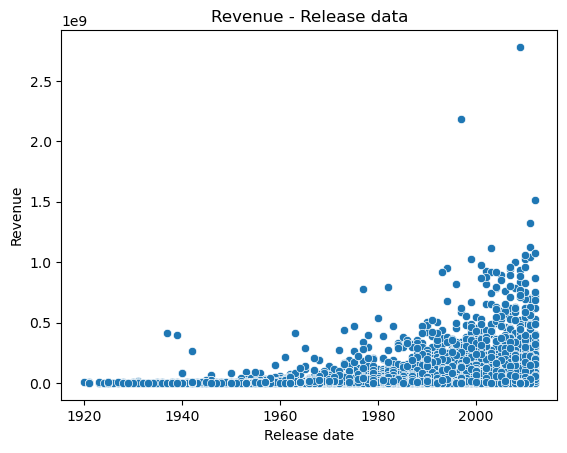

In [24]:
# Year - Revnue
sns.scatterplot(x=df_movie["Release date"], y=df_movie["Revenue"])
plt.title("Revenue - Release data")

### Relationship between Genres and Movie Revenue

In [25]:
from collections import Counter, defaultdict

# movie revenue for each language
genre_revenue = defaultdict(list)
genre_count = Counter()
for index, row in df_movie.iterrows():
    genres = json.loads(row["Genres"]).values()
    for genre in genres:
        genre_count[genre] += 1
        genre_revenue[genre].append(row["Revenue"])

print("Total {} genres.".format(len(country_revenue)))

Total 40 genres.


Top 20 genre, revenue


Text(0.5, 1.0, 'average movie revenue for top 20 genres')

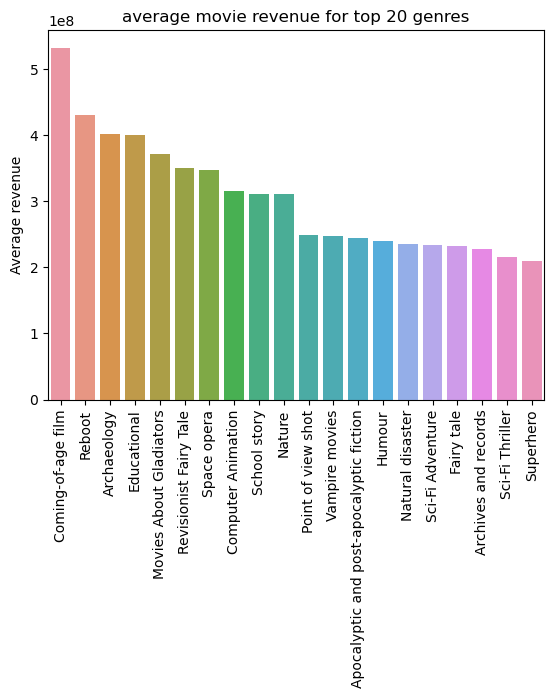

In [26]:
# mean for each genre
mean_genre_rev = {k:sum(v)/len(v) for k,v in genre_revenue.items()}
# sroted mean for each genre
sorted_mgr = sorted(mean_genre_rev.items(), key=lambda x:x[1], reverse=True)
sorted_mgr = pd.Series(*list(zip(*sorted_mgr))[::-1], name="Average revenue")

topk = 20
print("Top {} genre, revenue".format(topk))
sns.barplot(x=sorted_mgr.index[:topk], y=sorted_mgr[:topk])
plt.ylabel("Average revenue")
plt.xticks(rotation=90)
plt.title("average movie revenue for top {} genres".format(topk))

### Relationship between Actor and Movie Revenue

In [27]:
df_actor_movie = df_character.merge(df_movie, on="Freebase movie ID", how="left").dropna()

print(df_actor_movie.shape)
df_actor_movie.head()

(21394, 22)


,Wikipedia movie ID_x,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height(in meters),Actor ethnicity(Freebase ID),Actor name,Actor age at movie release,...,Freebase actor ID,Wikipedia movie ID_y,Name,Release date,Revenue,Runtime,Languages,Countries,Genres,Revenue_ratio
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,...,/m/0346l4,975900.0,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",0.000946
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,...,/m/01vw26l,975900.0,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",0.000946
5,975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,...,/m/0418ft,975900.0,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",0.000946
76,612710,/m/02wjqm,1999-10-01,Sandii,1975-09-20,F,1.680,/m/0222qb,Asia Argento,24.0,...,/m/028pzq,612710.0,New Rose Hotel,1999.0,21521.0,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",0.000002
77,612710,/m/02wjqm,1999-10-01,Fox,1943-03-31,M,1.830,/m/01qhm_,Christopher Walken,56.0,...,/m/016fjj,612710.0,New Rose Hotel,1999.0,21521.0,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",0.000002


<AxesSubplot:xlabel='Actor age at movie release', ylabel='Revenue'>

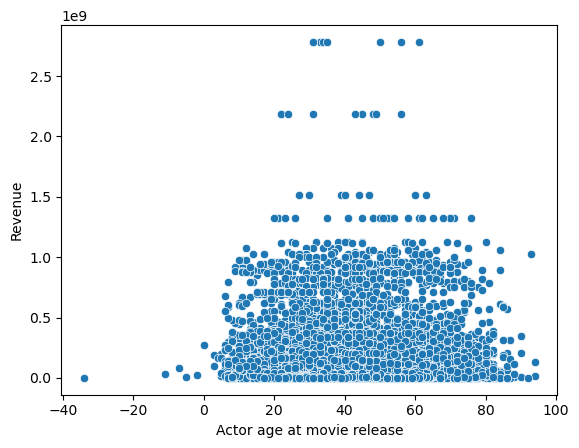

In [28]:
sns.scatterplot(data=df_actor_movie, x="Actor age at movie release", y="Revenue")

### Movie Title Analysis

In [29]:
movie_name = df_movie["Name"].astype('str')
movie_name

0                 Ghosts of Mars
1       Alexander's Ragtime Band
2                        Henry V
3                   Mary Poppins
4                 New Rose Hotel
                  ...           
8238                       Wilde
8239           Coming to America
8240             Spaced Invaders
8241              State and Main
8242               Guilty as Sin
Name: Name, Length: 8240, dtype: object

In [30]:
def transform_mask(imagename):
    mask = np.array(Image.open(f"./images/{imagename}.png"))
    mask = mask[:,:,0] # transform 3d image to 2d for easier visualization

    def transform_format(val):
        if val.any()== 0:
            return 255
        else:
            return val

    # Transform your mask into a new one that will work with the function
    transformed_mask = np.ndarray((mask.shape[0],mask.shape[1]), np.int32)

    for i in range(len(mask)):
        transformed_mask[i] = list(map(transform_format,mask[i]))

    return transformed_mask


/Users/yfsong/opt/anaconda3/envs/dis/lib/python3.8/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/yfsong/opt/anaconda3/envs/dis/lib/python3.8/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/yfsong/opt/anaconda3/envs/dis/lib/python3.8/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/yfsong/opt/anaconda3/envs/dis/lib/python3.8/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023

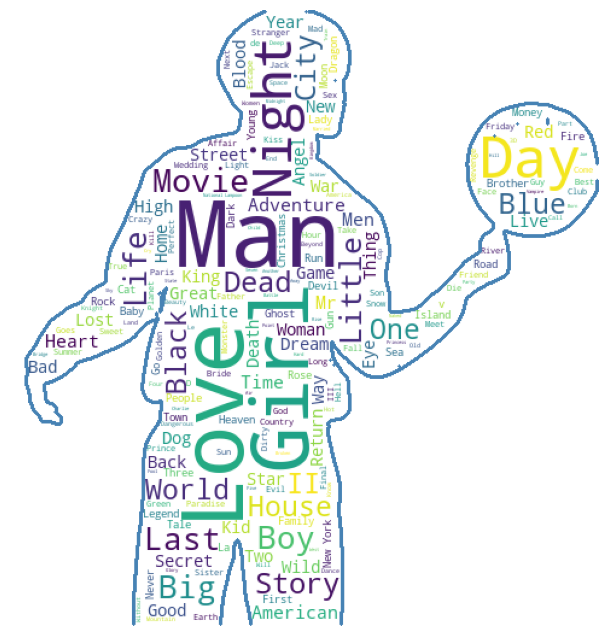

In [31]:
title_corpus = ' '.join(movie_name)
mask = np.array(Image.open("./images/background1.png"))
mask_trans = mask[:, :, 0]
mask_trans = transform_mask("background1")
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=800, width=600, mask = mask_trans, contour_width = 3,\
    contour_color = 'steelblue').generate(title_corpus)
title_wordcloud.to_file("./images/movie_title.png")
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

### Movie Plot Summary Analysis


In [32]:
model = LdaModel(corpus,id2word=dictionary,num_topics=5)
model.show_topics()

[(0,
  '0.004*"one" + 0.003*"film" + 0.003*"tells" + 0.002*"father" + 0.002*"find" + 0.002*"back" + 0.002*"house" + 0.002*"home" + 0.002*"finds" + 0.002*"love"'),
 (1,
  '0.003*"one" + 0.003*"tells" + 0.003*"back" + 0.003*"father" + 0.003*"life" + 0.002*"finds" + 0.002*"get" + 0.002*"takes" + 0.002*"’" + 0.002*"man"'),
 (2,
  '0.003*"get" + 0.003*"back" + 0.003*"also" + 0.003*"man" + 0.003*"find" + 0.002*"tells" + 0.002*"finds" + 0.002*"one" + 0.002*"two" + 0.002*"home"'),
 (3,
  '0.003*"love" + 0.003*"two" + 0.003*"one" + 0.003*"film" + 0.003*"back" + 0.003*"tells" + 0.002*"father" + 0.002*"get" + 0.002*"man" + 0.002*"time"'),
 (4,
  '0.003*"one" + 0.003*"back" + 0.003*"time" + 0.003*"life" + 0.002*"man" + 0.002*"two" + 0.002*"home" + 0.002*"police" + 0.002*"get" + 0.002*"house"')]

In [33]:
lda = LdaModel(corpus_tfidf, id2word = dictionary, num_topics = 5)
model.save(r'./save/lda_model.model')
model.show_topics()

[(0,
  '0.004*"one" + 0.003*"film" + 0.003*"tells" + 0.002*"father" + 0.002*"find" + 0.002*"back" + 0.002*"house" + 0.002*"home" + 0.002*"finds" + 0.002*"love"'),
 (1,
  '0.003*"one" + 0.003*"tells" + 0.003*"back" + 0.003*"father" + 0.003*"life" + 0.002*"finds" + 0.002*"get" + 0.002*"takes" + 0.002*"’" + 0.002*"man"'),
 (2,
  '0.003*"get" + 0.003*"back" + 0.003*"also" + 0.003*"man" + 0.003*"find" + 0.002*"tells" + 0.002*"finds" + 0.002*"one" + 0.002*"two" + 0.002*"home"'),
 (3,
  '0.003*"love" + 0.003*"two" + 0.003*"one" + 0.003*"film" + 0.003*"back" + 0.003*"tells" + 0.002*"father" + 0.002*"get" + 0.002*"man" + 0.002*"time"'),
 (4,
  '0.003*"one" + 0.003*"back" + 0.003*"time" + 0.003*"life" + 0.002*"man" + 0.002*"two" + 0.002*"home" + 0.002*"police" + 0.002*"get" + 0.002*"house"')]

In [34]:
vis = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis)

/Users/yfsong/opt/anaconda3/envs/dis/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/yfsong/opt/anaconda3/envs/dis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yfsong/opt/anaconda3/envs/dis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yfsong/opt/anaconda3/envs/dis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/